## Definition des fonctions 

In [2]:
import sys
chemin_modules = "/Users/aurelien/Desktop/PhD/Codes/Package/Perso/"
sys.path.append(chemin_modules)
import viz
import calculate
import read
import to_PDR
import pandas as pd

import scipy.constants as const
C_LIGHT = 299792458

def ghz_en_micrometres(frequence_ghz: float) -> float:
  if frequence_ghz == 0:
    return float('inf')
  frequence_hz = frequence_ghz * 1e9
  longueur_onde_m = C_LIGHT / frequence_hz
  longueur_onde_um = longueur_onde_m * 1e6
  return longueur_onde_um



def kelvin_en_micrometres(temperature_k: float) -> float:
  if temperature_k == 0:
    return float('inf')

  # Constantes physiques
  h = const.h    
  c = const.c        
  k_B = const.k      

  # lambda = (h * c) / (k_B * T)
  longueur_onde_m = (h * c) / (k_B * temperature_k)
  longueur_onde_um = longueur_onde_m * 1e6
  return longueur_onde_um

def micrometres_en_ghz(longueur_onde_um: float) -> float:
    if not longueur_onde_um or longueur_onde_um == 0:
        return None # Retourne None si la valeur est nulle ou manquante

    # Conversion de micromètres en mètres
    longueur_onde_m = longueur_onde_um * 1e-6
    # Calcul de la fréquence en Hertz (f = c / lambda)
    frequence_hz = const.c / longueur_onde_m
    # Conversion de Hertz en Gigahertz
    frequence_ghz = frequence_hz * 1e-9
    return frequence_ghz

def micrometres_en_kelvin(longueur_onde_um: float) -> float:
    if not longueur_onde_um or longueur_onde_um == 0:
        return None # Retourne None si la valeur est nulle ou manquante

    # Conversion de micromètres en mètres
    longueur_onde_m = longueur_onde_um * 1e-6
    # Calcul de l'énergie en Kelvin (T = h*c / (lambda*k_B))
    energie_k = (const.h * const.c) / (longueur_onde_m * const.k)
    return energie_k

#-------------------------------------------------
import re

def decomposer_ligne(line_string: str) -> tuple:
    """
    Décompose une chaîne d'identification de ligne spectroscopique.

    Args:
        line_string: La chaîne à analyser (ex: "CO 1-0 R(11)").

    Returns:
        Un tuple de 4 entiers (vu, Ju, vl, Jl).
        Retourne (None, None, None, None) si le format est incorrect.
    """
    try:
        # Sépare les parties principales: "CO", "1-0", "R(11)"
        parts = line_string.split()
        v_part = parts[1]
        j_part = parts[2]

        # Extrait les niveaux vibrationnels (v)
        vu, vl = map(int, v_part.split('-'))

        # Extrait le niveau rotationnel inférieur (Jl)
        jl = int(re.search(r'(\d+)', j_part).group(1))

        # Détermine le niveau rotationnel supérieur (Ju) selon la branche (P, Q, R)
        branch = j_part[0]
        if branch == 'R':
            ju = jl + 1
        elif branch == 'P':
            ju = jl - 1
        else: # Pour la branche Q (et par défaut)
            ju = jl

        return vu, ju, vl, jl

    except (IndexError, AttributeError, ValueError):
        # Si la ligne n'a pas le format attendu, on renvoie des valeurs nulles
        return None, None, None, None


def fusionner_niveaux(df_transitions: pd.DataFrame, df_niveaux: pd.DataFrame) -> pd.DataFrame:
    """
    Fusionne un DataFrame de transitions avec un DataFrame de niveaux d'énergie.

    Args:
        df_transitions: DataFrame avec les colonnes 'nu' (niveau supérieur) et 'nl' (niveau inférieur).
        df_niveaux: DataFrame de référence avec les colonnes 'n', 'v', et 'J'.

    Returns:
        Un DataFrame fusionné avec les colonnes 'vu', 'Ju', 'vl', 'Jl' ajoutées.
    """
    df_merged = pd.merge(df_transitions,df_niveaux,
        left_on='nu', right_on='n')
    df_merged = df_merged.rename(columns={'v': 'vu', 'J': 'Ju'})
    df_merged = df_merged.drop(columns='n')

    df_final = pd.merge(df_merged,df_niveaux,
        left_on='nl', right_on='n')
    df_final = df_final.rename(columns={'v': 'vl', 'J': 'Jl'})
    df_final = df_final.drop(columns='n')

    return df_final

def fusionner_par_niveaux(df_principal: pd.DataFrame, df_secondaire: pd.DataFrame, colonnes_a_ajouter: list) -> pd.DataFrame:
    """
    Fusionne deux DataFrames en ajoutant des colonnes de df_secondaire à df_principal.

    La fusion se fait sur les lignes où les quatre colonnes ('vu', 'Ju', 'vl', 'Jl')
    sont identiques dans les deux DataFrames.

    Args:
        df_principal: Le DataFrame principal (gauche) auquel on ajoute des colonnes.
        df_secondaire: Le DataFrame (droit) contenant les données à ajouter.
        colonnes_a_ajouter: Une liste des noms de colonnes à transférer depuis df_secondaire.

    Returns:
        Un nouveau DataFrame fusionné.
    """
    # Définir les clés sur lesquelles la fusion doit se baser
    cles_de_fusion = ['vu', 'Ju', 'vl', 'Jl']

    # S'assurer que le DataFrame secondaire ne contient que les clés et les colonnes à ajouter
    # pour éviter les colonnes en double non désirées.
    colonnes_a_garder = cles_de_fusion + colonnes_a_ajouter
    df_secondaire_selection = df_secondaire[colonnes_a_garder]

    # Effectuer la fusion de type 'left'
    df_fusionne = pd.merge(
        df_principal,
        df_secondaire_selection,
        on=cles_de_fusion,
        how='left'  # Important: garde toutes les lignes de df_principal
    )

    return df_fusionne
    

In [3]:
print(ghz_en_micrometres(62802.393))

4.77358335692718


In [4]:
print(kelvin_en_micrometres(3041.04))
print(kelvin_en_micrometres(3020.112))

4.731200107541938
4.763985168443865


## Importation des données JWST 

In [5]:
import pandas as pd
import io
import re 

def creer_dataframe_co(chemin_fichier: str) -> pd.DataFrame:
    """
    Crée un DataFrame Pandas à partir d'un fichier de données à largeur fixe,
    en utilisant des spécifications prédéfinies, et ne conserve que les lignes
    contenant 'CO' dans la colonne 'Line'.

    Args:
        chemin_fichier: Le chemin vers le fichier de données (ex: 'tableb1.dat').

    Returns:
        Un DataFrame Pandas filtré contenant uniquement les données du CO.
    """
    # 1. Spécifications extraites du README
    col_positions = [
        (0, 19), (19, 20), (20, 22), (23, 29), (30, 36), (37, 45),
        (46, 54), (55, 61), (62, 70), (71, 79), (80, 86), (87, 95),
        (96, 104), (105, 111), (112, 120), (121, 129), (130, 136),
        (137, 145), (146, 154)
    ]

    col_noms = [
        'Line', 'n_Line', 'NLine', 'Wave', 'HIIwavefit', 'HIIInt', 'e_HIIInt',
        'APDRwavefit', 'APDRInt', 'e_APDRInt', 'DF1wavefit', 'DF1Int', 'e_DF1Int',
        'DF2wavefit', 'DF2Int', 'e_DF2Int', 'DF3wavefit', 'DF3Int', 'e_DF3Int'
    ]

    # 2. Lecture du fichier complet
    try:
        df_complet = pd.read_fwf(
            chemin_fichier,
            colspecs=col_positions,
            names=col_noms,
            header=None
        )

        # 3. Filtrage pour ne garder que les lignes contenant "CO"
        # On utilise .str.contains() qui est très efficace pour ce type de recherche.
        # na=False assure que les lignes vides dans la colonne 'Line' ne causent pas d'erreur.
        # .copy() est une bonne pratique pour éviter les avertissements de Pandas.
        df_co = df_complet[df_complet['Line'].str.contains("CO", na=False)].copy()

        # 4. Nettoyage des colonnes de type texte du DataFrame filtré
        for col in df_co.select_dtypes(include=['object']).columns:
            df_co[col] = df_co[col].str.strip()

        return df_co

    except FileNotFoundError:
        print(f"❌ Erreur : Le fichier '{chemin_fichier}' est introuvable.")
        return pd.DataFrame() # Retourne un DataFrame vide en cas d'erreur

In [6]:
path ="/Users/aurelien/Desktop/PhD/Data/0_JWST_ORION/Orion_JWST/"
name = "JWST_Peeters2024.dat"

df_co_JWST = creer_dataframe_co(path+ name)

#Ajout des colonnes de GHz et K pour comparer aux données du code PDR 
df_co_JWST['Freq_GHz'] = df_co_JWST['DF1wavefit'].apply(micrometres_en_ghz)
df_co_JWST['Energy_K'] = df_co_JWST['DF1wavefit'].apply(micrometres_en_kelvin)
df_co_JWST[['vu', 'Ju', 'vl', 'Jl']] = df_co_JWST['Line'].apply(
    lambda line: pd.Series(decomposer_ligne(line)))

## Importation des données PDR

In [7]:
df_level_CO = to_PDR.Level_to_pd( "co")
df_lines_CO = to_PDR.Lines_to_pd("co")
df_lines_CO_New = to_PDR.Lines_to_pd("co",version="HITRAN")

#df_PDR = fusionner_niveaux(df_lines_CO,df_level_CO)  #df_lines de CO a déja la specificiation des vu Ju, vl, Jl
df_lines_CO['Freq'] = df_lines_CO['Description'].str.extract(r'(\d+\.?\d*)', expand=False).astype(float) #Récupérer la fréquence


['n', 'g', 'En(K)', 'o', 'v', 'J', 'comment']
Skipping malformed or incomplete line: #---end--------------------------------------------------------------------------------------------------------------------------- - Error: invalid literal for int() with base 10: '#---end---------------------------------------------------------------------------------------------------------------------------'
Skipping malformed or incomplete line: # Aij from our 3 independant sources - Error: invalid literal for int() with base 10: '#'
Skipping malformed or incomplete line: # => Goorvitch, 1994, ApJSS, 95, 535 if possible - Error: invalid literal for int() with base 10: '#'
Skipping malformed or incomplete line: # => else Huré & Roueff, 1996, A&AS, 117, 561 if possible - Error: invalid literal for int() with base 10: '#'
Skipping malformed or incomplete line: # => else Chandra et al., 1996, A&AS, 117, 557 - Error: invalid literal for int() with base 10: '#'


In [8]:
# Fusion du df_JWST et du df_PDR pour comparer les longueurs d'onde 
df_CO_comparaison = fusionner_par_niveaux(df_co_JWST,df_lines_CO,["E_K","Freq"])
df_CO_comparaison.columns

def difference_pourcentage(df: pd.DataFrame, col1: str, col2: str) -> pd.Series:
    return ((df[col2] - df[col1]) / df[col1]) * 100
    
df_CO_comparaison['Ecart_relatif_%'] = difference_pourcentage(df_CO_comparaison, 'Freq_GHz', 'Freq')    


In [9]:
df_CO_comparaison


,Line,n_Line,NLine,Wave,HIIwavefit,HIIInt,e_HIIInt,APDRwavefit,APDRInt,e_APDRInt,...,e_DF3Int,Freq_GHz,Energy_K,vu,Ju,vl,Jl,E_K,Freq,Ecart_relatif_%
0,CO 1-0 R(11),+,23.0,4.5732,4.5735,0.000003,2.880000e-07,4.5737,0.000003,4.040000e-07,...,7.370000e-07,65551.331176,3145.967721,1,12,0,11,3146.086,65553.790,0.003751
1,CO 1-0 R(10),NaN,NaN,4.5804,4.5807,0.000001,2.840000e-07,NaN,NaN,NaN,...,7.150000e-07,65452.581272,3141.228473,1,11,0,10,3141.172,65451.402,-0.001802
2,CO 1-0 R(9),NaN,NaN,4.5876,NaN,NaN,NaN,NaN,NaN,NaN,...,8.110000e-07,65348.430116,3136.230006,1,10,0,9,3136.206,65347.917,-0.000785
3,CO 1-0 R(8),+,24.0,4.5950,4.5954,0.000003,6.560000e-07,4.5955,0.000003,2.590000e-07,...,8.490000e-07,65238.930647,3130.974860,1,9,0,8,3131.187,65243.339,0.006757
4,CO 1-0 R(7),NaN,NaN,4.6024,NaN,NaN,NaN,4.6025,0.000003,4.650000e-07,...,8.350000e-07,65129.797523,3125.737296,1,8,0,7,3126.115,65137.671,0.012089
5,CO 1-0 R(6),NaN,NaN,4.6100,4.6097,0.000001,NaN,NaN,NaN,NaN,...,8.360000e-07,65029.491334,3120.923359,1,7,0,6,3120.992,65030.919,0.002195
6,CO 2-1 R(13),NaN,NaN,4.6160,NaN,NaN,NaN,NaN,NaN,NaN,...,5.240000e-07,NaN,NaN,2,14,1,13,3116.951,64946.717,NaN
7,CO 1-0 R(5),+,25.0,4.6177,4.6178,0.000148,4.680000e-06,4.6178,0.000090,1.520000e-06,...,5.970000e-07,64921.057213,3115.719341,1,6,0,5,3115.817,64923.086,0.003125
8,CO 2-1 R(12),NaN,NaN,4.6230,NaN,NaN,NaN,NaN,NaN,NaN,...,2.460000e-07,NaN,NaN,2,13,1,12,3112.194,64847.587,NaN
9,CO 1-0 R(4),NaN,NaN,4.6254,NaN,NaN,NaN,4.6256,0.000001,5.980000e-07,...,3.430000e-07,64805.978815,3110.196449,1,5,0,4,3110.590,64814.177,0.012650


## Partie Graphique 

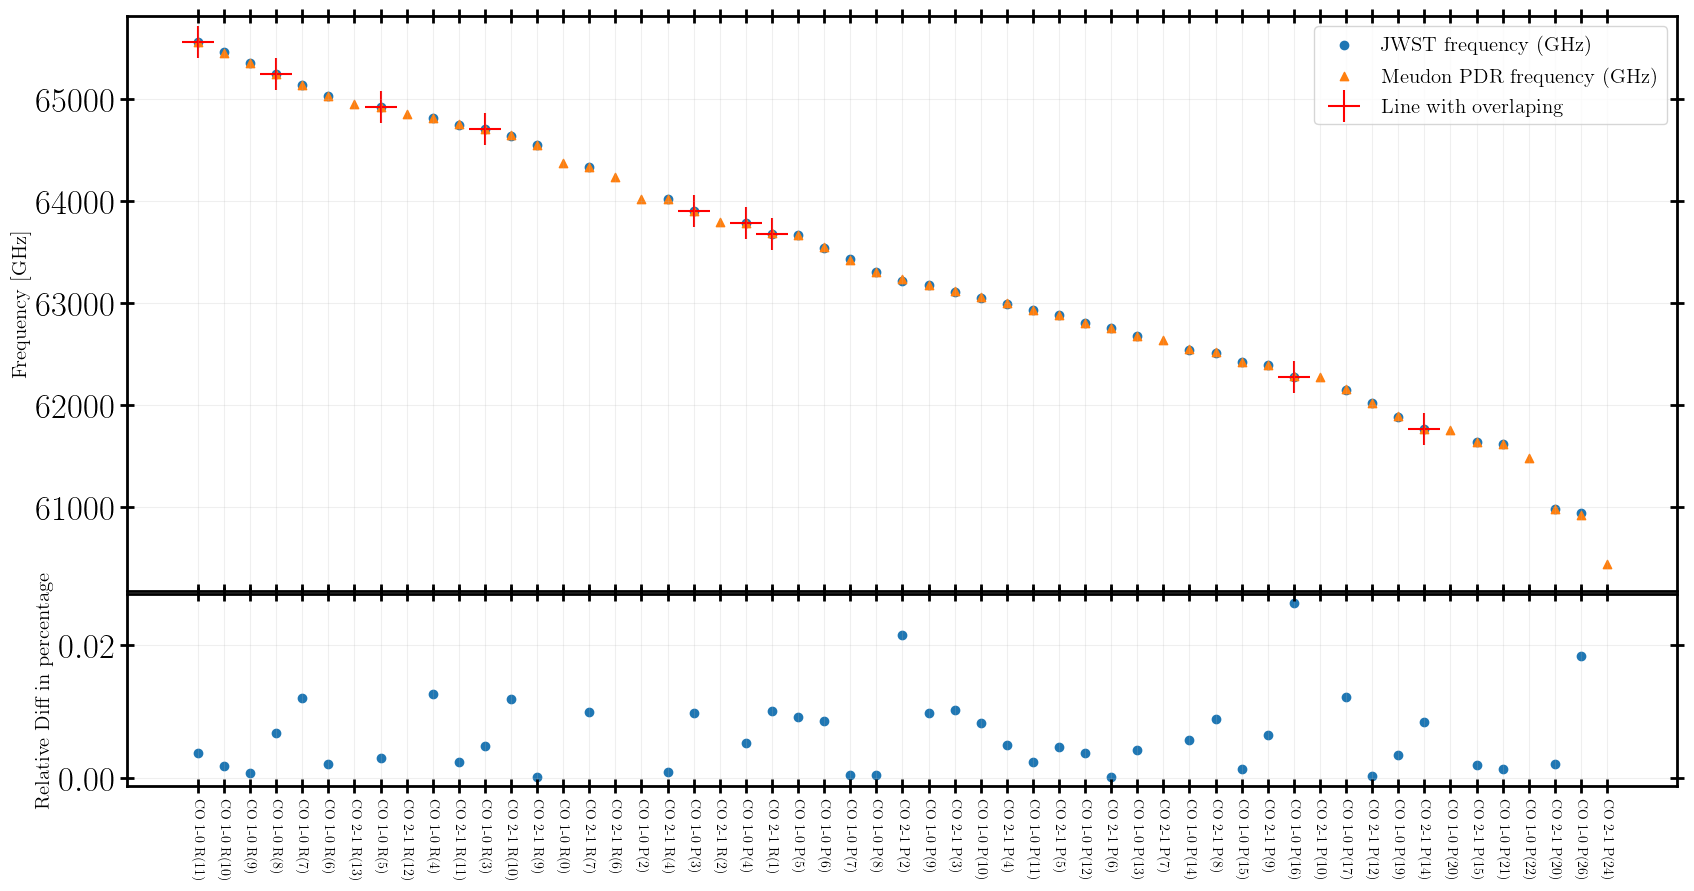

In [11]:
viz.Setting_Figure("Excitation")
import matplotlib.pyplot as plt

outputpath = "/Users/aurelien/Desktop/PhD/Results/CO_JWST_Orion/"
fig, (ax1, ax2) = plt.subplots(
        2, 1, 
        figsize=(20,10), 
        sharex=True, 
        gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.01})


ax1.scatter(df_CO_comparaison["Line"],df_CO_comparaison["Freq_GHz"], 
           marker="o", label="JWST frequency (GHz)")
ax1.scatter(df_CO_comparaison["Line"],df_CO_comparaison["Freq"], 
           marker="^", label="Meudon PDR frequency (GHz)")

df_filtre = df_CO_comparaison[df_CO_comparaison['n_Line'].notna()]
ax1.scatter(
    df_filtre['Line'],df_filtre['Freq_GHz'],marker ='+', c="r",s=500,label="Line with overlaping")

ax1.set_ylabel("Frequency [GHz]")
ax1.legend()
ax1.grid("--",alpha=0.2)

ax2.scatter(df_CO_comparaison["Line"],abs(df_CO_comparaison["Ecart_relatif_%"]), 
           marker="o", label="Ecart Relatif [%]")
ax2.set_ylabel("Relative Diff in percentage")
ax2.grid("--",alpha=0.2)

plt.xticks(rotation=-90,size=10)
plt.tight_layout()

plt.savefig(outputpath+"FrequencyComp_Peeters_PDR.pdf")